In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
# Set environment variable to ignore all warnings
os.environ['PYTHONWARNINGS'] = 'ignore'

import subprocess
import time
import random

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.families.links import Log
from scipy.stats import skew

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [5]:
df = pd.read_csv('dataset.csv', index_col = 0)
df = df.rename(columns={'agarald': 'Alter',
                        'kon': 'Geschlecht',
                        'zon': 'Zone',
                        'mcklass': 'Fahrzeugtyp',
                        'fordald': 'Fahrzeugalter',
                        'bonuskl': 'Bonusklasse',
                        'duration': 'Versicherungsjahre',
                        'antskad': 'Schadenanzahl',
                        'skadkost': 'Schadenaufwendungen'})
df['Geschlecht'] = le.fit_transform(df['Geschlecht'])

In [7]:
# Claim frequency
df1 = df[df['Versicherungsjahre'] != 0]
train1, test1 = train_test_split(df1, test_size=0.3, random_state=777)

# Define features (X) for XGB
feature_list1 = ['Alter','Geschlecht','Zone'
                 ,'Fahrzeugtyp','Fahrzeugalter','Bonusklasse'
                 ,'Schadenaufwendungen']

# labels
y_train1 = train1['Schadenanzahl']
y_test1 = test1['Schadenanzahl']

# features
X_train1 = train1[feature_list1]
X_test1 = test1[feature_list1]

# weights
weight_train1 = train1['Versicherungsjahre']
weight_test1 = test1['Versicherungsjahre']


# Claim severity
df2 = df[df['Schadenanzahl'] > 0]
train2, test2 = train_test_split(df2, test_size=0.3, random_state=777)

# Define features (X) for XGB
feature_list2 = ['Alter','Geschlecht','Zone'
                 ,'Fahrzeugtyp','Fahrzeugalter','Bonusklasse'
                 ,'Versicherungsjahre']

# labels
y_train2 = train2['Schadenaufwendungen']
y_test2 = test2['Schadenaufwendungen']

# features
X_train2 = train2[feature_list2]
X_test2 = test2[feature_list2]

# weights
weight_train2 = train2['Schadenanzahl']
weight_test2 = test2['Schadenanzahl']

In [9]:
# Weighted Poisson Deviance
def WPD(predicted, observed, exposure=None):
    if exposure is None:
        exposure = np.ones(len(observed))
    
    # Compute the numerator (weighted Poisson deviance)
    numerator = np.sum(exposure * (predicted - observed + observed * np.log(observed / predicted)))
    
    # Compute the denominator (total exposure)
    denominator = np.sum(exposure)
    
    # Normalize and scale
    deviance = 200 * numerator / denominator
    return deviance

# I. Claim frequency modelling

## I.I. Generalized Linear Model (GLM)

In [11]:
# GLM0 (Intercept-Model)
CF_0 = sum(train1.Schadenanzahl) / sum(train1.Versicherungsjahre)
train1["CF_0"] = CF_0 * train1.Versicherungsjahre
test1["CF_0"] = CF_0 * test1.Versicherungsjahre

# Claim frequency actual vs predicted GLM0
print("%s: %.2f %% / %.2f %%" % ("Claim Frequency GLM0, Test, Actual / Predicted",
                                 sum(test1.Schadenanzahl)/sum(test1.Versicherungsjahre) * 100,
                                 sum(test1.CF_0)/sum(test1.Versicherungsjahre) * 100))

# Poisson deviance GLM0
print("%s, Train / Test: %.2f %% / %.2f %%" % ("Poisson Deviance GLM0",
                                             WPD(train1.CF_0, train1.Schadenanzahl, train1.Versicherungsjahre),
                                             WPD(test1.CF_0, test1.Schadenanzahl, test1.Versicherungsjahre)))

Claim Frequency GLM0, Test, Actual / Predicted: 1.00 % / 1.09 %
Poisson Deviance GLM0, Train / Test: 8.75 % / 7.50 %


C:\Users\hansa\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
root_mean_squared_error(test1.Schadenanzahl, test1.CF_0)

0.10655736421128408

In [17]:
# GLM1
CF_glm1 = smf.glm("Schadenanzahl ~ Alter + Geschlecht + Zone + Fahrzeugtyp + Fahrzeugalter + Bonusklasse",
                family=sm.families.Poisson(), offset = np.log(train1.Versicherungsjahre), data=train1)
CF_glm_fit1 = CF_glm1.fit(method='newton')
CF_glm_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Schadenanzahl   No. Observations:                43731
Model:                            GLM   Df Residuals:                    43724
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                        newton   Log-Likelihood:                -2568.7
Date:                Mon, 17 Feb 2025   Deviance:                       4166.4
Time:                        15:57:18   Pearson chi2:                 1.06e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01306
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.2653      0.253     -5.009      0.000      -1.760      -0.770
Alter            -0.0613      0.004    -14.809      0.000      -0.069      -0.053
Geschlecht        0.4310      0.160      2.692      0.007       0.117       0.745
Zone             -0.4197      0.036    -11.513      0.000      -0.491      -0.348
Fahrzeugtyp       0.1430      0.034      4.261      0.000       0.077       0.209
Fahrzeugalter    -0.0709      0.008     -9.412      0.000      -0.086      -0.056
Bonusklasse       0.0385      0.021      1.876      0.061      -0.002       0.079
=================================================================================
"""

In [15]:
# Predictions GLM1
train1["CF_glm_fit1"] = CF_glm_fit1.predict(train1) * train1.Versicherungsjahre
test1["CF_glm_fit1"] = CF_glm_fit1.predict(test1) * test1.Versicherungsjahre

In [17]:
# Claim frequency actual vs predicted GLM1
print("%s: %.2f %% / %.2f %%" % ("Claim Frequency GLM1, Test, Actual / Predicted",
                                 sum(test1.Schadenanzahl)/sum(test1.Versicherungsjahre) * 100,
                                 sum(test1.CF_glm_fit1)/sum(test1.Versicherungsjahre) * 100))

# Poisson deviance GLM1
print("%s, Train / Test: %.2f %% / %.2f %%" % ("Poisson Deviance GLM1",
                                             WPD(train1.CF_glm_fit1, train1.Schadenanzahl, train1.Versicherungsjahre),
                                             WPD(test1.CF_glm_fit1, test1.Schadenanzahl, test1.Versicherungsjahre)))

Claim Frequency GLM1, Test, Actual / Predicted: 1.00 % / 1.10 %
Poisson Deviance GLM1, Train / Test: 8.49 % / 6.83 %


C:\Users\hansa\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
root_mean_squared_error(test1.Schadenanzahl, CF_glm_fit1.predict(test1))

0.1054838428622852

In [21]:
# GLM2
CF_glm2 = smf.glm("Schadenanzahl ~ Alter + Geschlecht + Zone + Fahrzeugtyp + Fahrzeugalter + Bonusklasse + Bonusklasse * Zone",
                family=sm.families.Poisson(), offset = np.log(train1.Versicherungsjahre), data=train1)
CF_glm_fit2 = CF_glm2.fit(method='newton')
#CF_glm_fit2.summary()

In [23]:
# Predictions GLM2
train1["CF_glm_fit2"] = CF_glm_fit2.predict(train1) * train1.Versicherungsjahre
test1["CF_glm_fit2"] = CF_glm_fit2.predict(test1) * test1.Versicherungsjahre

In [25]:
# Claim frequency actual vs predicted GLM2
print("%s: %.2f %% / %.2f %%" % ("Claim Frequency GLM2, Test, Actual / Predicted",
                                 sum(test1.Schadenanzahl)/sum(test1.Versicherungsjahre) * 100,
                                 sum(test1.CF_glm_fit2)/sum(test1.Versicherungsjahre) * 100))

# Poisson deviance GLM1
print("%s, Train / Test: %.2f %% / %.2f %%" % ("Poisson Deviance GLM2",
                                             WPD(train1.CF_glm_fit2, train1.Schadenanzahl, train1.Versicherungsjahre),
                                             WPD(test1.CF_glm_fit2, test1.Schadenanzahl, test1.Versicherungsjahre)))

Claim Frequency GLM2, Test, Actual / Predicted: 1.00 % / 1.10 %
Poisson Deviance GLM2, Train / Test: 8.38 % / 6.76 %


C:\Users\hansa\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [27]:
root_mean_squared_error(test1.Schadenanzahl, CF_glm_fit2.predict(test1))

0.10545806781336066

## I.II. Extreme Gradient Boosting (XGBoost)

In [29]:
# XGB
model_xgb = XGBRegressor(objective = 'count:poisson', eval_metric='poisson-nloglik', 
                         tree_method = 'hist')
model_xgb_fit = model_xgb.fit(X_train1, y_train1, sample_weight = train1.Versicherungsjahre)

# Predictions XGB
train1["CF_XGB_fit"] = model_xgb_fit.predict(X_train1)
test1["CF_XGB_fit"] = model_xgb_fit.predict(X_test1)

# Claim frequency actual vs predicted XGB
print("%s: %.2f %% / %.2f %%" % ("Claim Frequency XGB, Test, Actual / Predicted",
                                 sum(test1.Schadenanzahl)/sum(test1.Versicherungsjahre) * 100,
                                 sum(test1.CF_XGB_fit)/sum(test1.Versicherungsjahre) * 100))

# Poisson deviance XGB
print("%s, Train / Test: %.2f %% / %.2f %%" % ("Poisson Deviance XGB",
                                             WPD(train1.CF_XGB_fit, train1.Schadenanzahl, train1.Versicherungsjahre),
                                             WPD(test1.CF_XGB_fit, test1.Schadenanzahl, test1.Versicherungsjahre)))

Claim Frequency XGB, Test, Actual / Predicted: 1.00 % / 1.01 %
Poisson Deviance XGB, Train / Test: 0.00 % / 0.12 %


C:\Users\hansa\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
root_mean_squared_error(test1.Schadenanzahl, model_xgb.predict(X_test1))

0.0253053878188382

# II. Claim severity modelling

## II.I. Generalized Linear Model (GLM)

In [33]:
# GLM0 (Intercept-Model)
CS_0 = sum(train2.Schadenaufwendungen) / sum(train2.Schadenanzahl)
train2["CS_0"] = CS_0 * train2.Schadenanzahl
test2["CS_0"] = CS_0 * test2.Schadenanzahl

# Claim severity actual vs predicted GLM0
print("%s: %.2f / %.2f" % ("Claim Severity GLM0, Test, Actual / Predicted",
                                 sum(test2.Schadenaufwendungen),
                                 sum(test2.CS_0)))

Claim Severity GLM0, Test, Actual / Predicted: 4762611.00 / 5116337.08


In [35]:
root_mean_squared_error(test2.Schadenaufwendungen, test2.CS_0)

38224.69601412378

In [37]:
# GLM1
CS_glm1 = smf.glm("Schadenaufwendungen ~ Alter + Geschlecht + Zone + Fahrzeugtyp + Fahrzeugalter + Bonusklasse",
                family=sm.families.Gamma(link=Log()), offset = np.log(train2.Schadenanzahl), data=train2)
CS_glm_fit1 = CS_glm1.fit(method='newton')
#CS_glm_fit1.summary()

In [39]:
# Predictions GLM1
train2["CS_glm_fit1"] = CS_glm_fit1.predict(train2) * train2.Schadenanzahl
test2["CS_glm_fit1"] = CS_glm_fit1.predict(test2) * test2.Schadenanzahl

In [41]:
# Claim frequency actual vs predicted GLM1
print("%s: %.2f / %.2f" % ("Claim Severity GLM1, Test, Actual / Predicted",
                                 sum(test2.Schadenaufwendungen),
                                 sum(test2.CS_glm_fit1)))

Claim Severity GLM1, Test, Actual / Predicted: 4762611.00 / 4861973.03


In [43]:
root_mean_squared_error(test2.Schadenaufwendungen, CS_glm_fit1.predict(test2))

38418.00431075823

## II.II. Extreme Gradient Boosting (XGBoost)

In [45]:
# XGB
model_xgb2 = XGBRegressor(objective = 'reg:squarederror', eval_metric='rmse', 
                         tree_method = 'hist')
model_xgb_fit2 = model_xgb2.fit(X_train2, y_train2)

# Predictions XGB
train2["CS_XGB_fit"] = model_xgb_fit2.predict(X_train2)
test2["CS_XGB_fit"] = model_xgb_fit2.predict(X_test2)

# Claim severity actual vs predicted XGB
print("%s: %.2f / %.2f " % ("Claim severity XGB, Test, Actual / Predicted",
                                 sum(test2.Schadenaufwendungen),
                                 sum(test2.CS_XGB_fit)))

Claim severity XGB, Test, Actual / Predicted: 4762611.00 / 4984814.42 


In [47]:
root_mean_squared_error(test2.Schadenaufwendungen, model_xgb_fit2.predict(X_test2))

42570.22487515837

In [ ]:
param_dist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0, 1, 10],
    "reg_alpha": [0, 0.1, 1],
    "n_estimators": [100, 300, 500]
}

xgb_reg = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    scoring="neg_mean_squared_error",
    n_iter=20,
    cv=3,
    verbose=1,
    random_state=42
)

random_search.fit(X_train2, y_train2)
print("Best parameters found:", random_search.best_params_)

In [ ]:
# param = {'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 5,
#          'learning_rate': 0.05, 'colsample_bytree': 0.8, 'objective' : 'reg:squarederror', 'eval_metric':'rmse', 'tree_method' : 'hist'}

In [ ]:
# # XGB
# model_xgb2 = XGBRegressor(**param)
# model_xgb_fit2 = model_xgb2.fit(X_train2, y_train2)

# # Predictions XGB
# train2["CS_XGB_fit"] = model_xgb_fit2.predict(X_train2)
# test2["CS_XGB_fit"] = model_xgb_fit2.predict(X_test2)

# # Claim severity actual vs predicted XGB
# print("%s: %.2f / %.2f " % ("Claim severity XGB, Test, Actual / Predicted",
#                                  sum(test2.Schadenaufwendungen),
#                                  sum(test2.CS_XGB_fit)))

In [ ]:
# root_mean_squared_error(test2.Schadenaufwendungen, model_xgb2.predict(X_test2))

# Picture for Latex

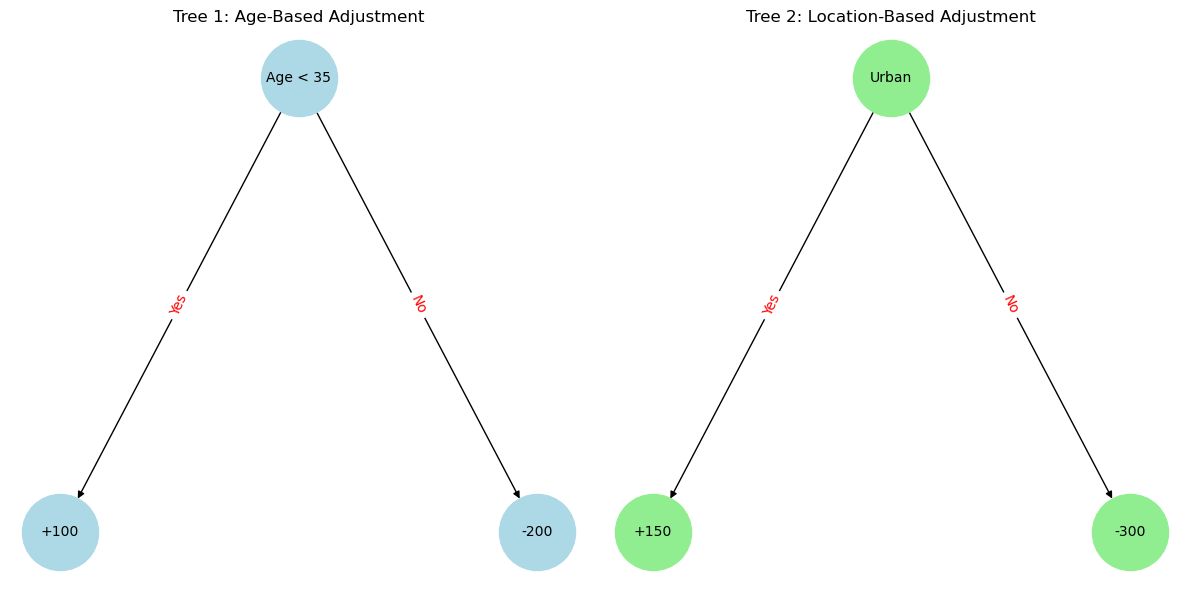

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

# Create two directed graphs
G1 = nx.DiGraph()
G2 = nx.DiGraph()

# Add nodes and edges for Tree 1 (Age-based decisions)
G1.add_edge("Age < 35", "+100", label="Yes")
G1.add_edge("Age < 35", "-200", label="No")

# Add nodes and edges for Tree 2 (Location-based decisions)
G2.add_edge("Urban", "+150", label="Yes")
G2.add_edge("Urban", "-300", label="No")

# Define positions for Tree 1
pos1 = {
    "Age < 35": (0, 2), "+100": (-1, 1), "-200": (1, 1)
}

# Define positions for Tree 2
pos2 = {
    "Urban": (0, 2), "+150": (-1, 1), "-300": (1, 1)
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Draw Tree 1 (Age-based)
plt.sca(axes[0])
nx.draw(G1, pos1, with_labels=True, node_color="lightblue", edge_color="black", node_size=3000, font_size=10)
edge_labels1 = {("Age < 35", "+100"): "Yes", ("Age < 35", "-200"): "No"}
nx.draw_networkx_edge_labels(G1, pos1, edge_labels=edge_labels1, font_size=10, font_color="red")
plt.title("Tree 1: Age-Based Adjustment")

# Draw Tree 2 (Location-based)
plt.sca(axes[1])
nx.draw(G2, pos2, with_labels=True, node_color="lightgreen", edge_color="black", node_size=3000, font_size=10)
edge_labels2 = {("Urban", "+150"): "Yes", ("Urban", "-300"): "No"}
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=edge_labels2, font_size=10, font_color="red")
plt.title("Tree 2: Location-Based Adjustment")

# Save and display the diagram
plt.tight_layout()
plt.savefig("tree1.png", format="png", dpi=300)  # Save before plt.show()
plt.show()
